<a href="https://colab.research.google.com/github/megha-puthukudi/main-project/blob/main/modeels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 1148 images belonging to 2 classes.
Found 248 images belonging to 2 classes.
Found 248 images belonging to 2 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/100
35/35 [==============================] - 276s 8s/step - loss: 0.5456 - accuracy: 0.7159 - val_loss: 0.4361 - val_accuracy: 0.7991
Epoch 2/100
35/35 [==============================] - 21s 594ms/step - loss: 0.3855 - accuracy: 0.8396 - val_loss: 0.3569 - val_accuracy: 0.8348
Epoch 3/100
35/35 [==============================] - 19s 554ms/step - loss: 0.3346 - accuracy: 0.8737 - val_loss: 0.3464 - val_accuracy: 0.8304
Epoch 4/100
35/35 [==============================] - 21s 607ms/step - loss: 0.3147 - accuracy: 0.8737 - val_loss: 0.3144 - val_accuracy: 0.8527
Epoch 5/100
35/35 [==============================] - 20s 561ms/step - loss: 0.2811 - accuracy: 0.8916 - val_loss: 0.3334 - val_accuracy: 0.8214
Epoch 6/100
35/35 [==============================] - 19s 553ms/step - loss: 0.2975 - accuracy

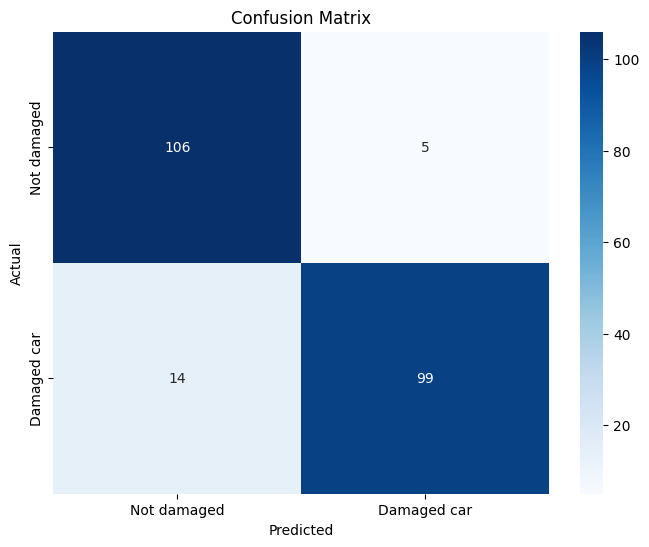

Test loss: 0.1781
Test accuracy: 93.30
Train loss: 0.1114
Train accuracy: 95.89
Recall: 0.92
Precision: 0.92
F1-score: 0.92


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator# Importing ImageDataGenerator for real-time data augmentation on image data
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten #Flatten layer is used to flatten the input data from a multi-dimensional shape into one-dimensional array
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns # Added seaborn for visualization (attractive and informative statistical graphics)

# Define your data directories
train_dir = '/content/drive/MyDrive/damaged dataset - Copy (2)/train'
val_dir = '/content/drive/MyDrive/damaged dataset - Copy (2)/validation'
test_dir = '/content/drive/MyDrive/damaged dataset - Copy (2)/test'

# Define image size and batch size
img_size = (224, 224)
batch_size = 32  # Batch size is the number of samples processed by the model at each iteration during training.

# Create data generators
train_datagen = ImageDataGenerator(
    # This initializes an ImageDataGenerator object named train_datagen responsible for generating augmented images from the original dataset during training.

    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest' # Fill newly created pixels with values from the nearest existing pixel(as it left shift or other).
)

val_datagen = ImageDataGenerator(rescale=1./255)# Rescale pixel values of validation images to [0, 1](for normalization process).
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,# Directory containing training images
    target_size=img_size,# Resize all images to the specified dimensions
    batch_size=batch_size,# Number of images in each batch
    class_mode='categorical'# For multi-class classification, use 'categorical' to get one-hot encoded labels

)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Flatten the output of VGG16
x = Flatten()(base_model.output)

# Add a fully connected layer for classification
predictions = Dense(2, activation='softmax')(x)  # Assuming 2 classes: car and damaged car

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=100,# Number of times the entire training dataset is passed through the model
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // batch_size)
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.n // batch_size)


# Calculate recall

y_true = []# List to store true labels
y_pred = []# List to store predicted labels
for i in range(test_generator.n // batch_size):
      # Retrieve the next batch of input images and their corresponding true labels
    batch_x, batch_y = next(test_generator)
        # Extract true labels from batch_y and append to y_true list
    y_true.extend(np.argmax(batch_y, axis=1))
    # Obtain model predictions for the input images in the current batch
    y_pred.extend(np.argmax(model.predict(batch_x), axis=1))


# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not damaged', 'Damaged car'], yticklabels=['Not damaged', 'Damaged car'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate other metrics
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Display metrics
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy * 100:.2f}')
print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_accuracy * 100:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1-score: {f1:.2f}')

# Save the trained model
model.save('/content/drive/MyDrive/colabtest/vecicle_damage_VGG16_batch16_newcrash_dataset_epoch100_changed_new_dataset.h5')


Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Epoch 1/100
105/105 [==============================] - 160s 1s/step - loss: 3.1187 - accuracy: 0.3643 - val_loss: 2.6914 - val_accuracy: 0.3807
Epoch 2/100
105/105 [==============================] - 16s 155ms/step - loss: 2.7564 - accuracy: 0.3810 - val_loss: 2.4651 - val_accuracy: 0.3977
Epoch 3/100
105/105 [==============================] - 16s 155ms/step - loss: 2.4874 - accuracy: 0.3857 - val_loss: 2.1854 - val_accuracy: 0.4205
Epoch 4/100
105/105 [==============================] - 17s 161ms/step - loss: 2.2132 - accuracy: 0.4274 - val_loss: 1.9433 - val_accuracy: 0.4773
Epoch 5/100
105/105 [==============================] - 16s 154ms/step - loss: 1.9614 - accuracy: 0.4619 - val_loss: 1.7144 - val_accuracy: 0.4943
Epoch 6/100
105/105 [==============================] - 17s 160ms/step - loss: 1.9353 - accuracy: 0.4583 - val_loss: 1.7028 - val_accuracy: 0.5170
Epo

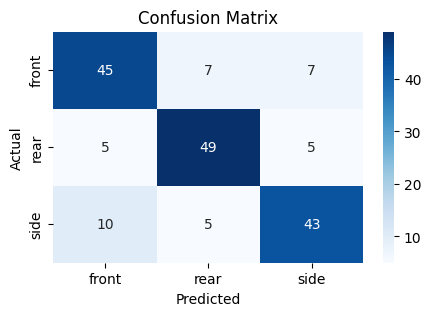

Test loss: 0.6883
Test accuracy: 77.27
Train loss: 0.5309
Train accuracy: 78.45
Recall: 0.78
Precision: 0.78
F1-score: 0.78


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16  # Changed to VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns  # Added seaborn for visualization

# Define your data directories
train_dir = '/content/drive/MyDrive/spot last/train'
val_dir = '/content/drive/MyDrive/spot last/validation'
test_dir = '/content/drive/MyDrive/spot last/test'

# Define image size and batch size
img_size = (224, 224)  # VGG16 requires input size to be (224, 224)
batch_size = 8 # Keep batch size as 32

# Create data generators with more aggressive data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,  # Update to VGG16 preprocessing
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)  # Update to VGG16 preprocessing
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)  # Update to VGG16 preprocessing

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Adjusted input shape

# Add a global average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Add a dense output layer with softmax activation
predictions = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model except the last few
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=100,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // batch_size)
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.n // batch_size)

# Calculate recall
y_true = []
y_pred = []
for i in range(test_generator.n // batch_size):
    batch_x, batch_y = next(test_generator)
    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred.extend(np.argmax(model.predict(batch_x), axis=1))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['front', 'rear', 'side'], yticklabels=['front', 'rear', 'side'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate other metrics
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
# Display metrics
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy * 100:.2f}')
print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_accuracy * 100:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1-score: {f1:.2f}')

# Save the trained model
model.save('/content/drive/MyDrive/colabtest/vecicle_spot_position_VGG16_tried8batchepoch_100_spotlast_dataset.h5')


Found 1040 images belonging to 3 classes.
Found 225 images belonging to 3 classes.
Found 225 images belonging to 3 classes.
80134624/80134624 [==============================] - 0s 0us/step


Epoch 1/100
65/65 [==============================] - 252s 4s/step - loss: 1.9682 - accuracy: 0.5154 - val_loss: 0.8121 - val_accuracy: 0.6384
Epoch 2/100
65/65 [==============================] - 19s 284ms/step - loss: 0.8070 - accuracy: 0.6192 - val_loss: 0.7927 - val_accuracy: 0.6250
Epoch 3/100
65/65 [==============================] - 19s 299ms/step - loss: 0.7603 - accuracy: 0.6500 - val_loss: 0.7261 - val_accuracy: 0.6429
Epoch 4/100
65/65 [==============================] - 18s 281ms/step - loss: 0.7335 - accuracy: 0.6606 - val_loss: 0.7491 - val_accuracy: 0.6562
Epoch 5/100
65/65 [==============================] - 18s 281ms/step - loss: 0.7417 - accuracy: 0.6500 - val_loss: 0.7328 - val_accuracy: 0.6161
Epoch 6/100
65/65 [==============================] - 18s 284ms/step - loss: 0.7524 - accuracy: 0.6538 - val_loss: 0.7701 - val_accuracy: 0.6205
Epoch 7/100
65/65 [==============================] - 18s 281ms/step - loss: 0.6829 - accuracy: 0.6933 - val_loss: 0.8043 - val_accuracy: 0

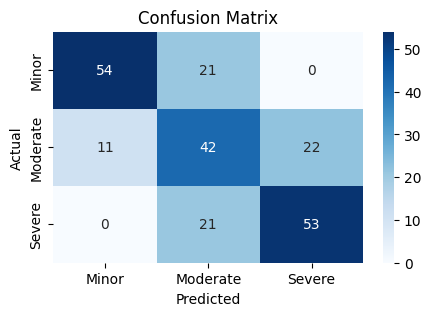

Test loss: 1.1874
Test accuracy: 66.52
Train loss: 0.2519
Train accuracy: 90.87
Recall: 0.67
Precision: 0.68
F1-score: 0.67


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns

# Define your data directories
train_dir = '/content/drive/MyDrive/datasets severe new/train'
val_dir = '/content/drive/MyDrive/datasets severe new/validation'
test_dir = '/content/drive/MyDrive/datasets severe new/test'

# Define image size and batch size
img_size = (224, 224)
batch_size = 16  # Increase batch size for faster convergence

# Create data generators with additional augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Reduce rotation range
    width_shift_range=0.1,  # Reduce shift range
    height_shift_range=0.1,  # Reduce shift range
    shear_range=0.1,  # Reduce shear range
    zoom_range=0.1,  # Reduce zoom range
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of VGG19
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)  # Reduce dropout rate
predictions = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze some layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with a smaller learning rate
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=100,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // batch_size)
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.n // batch_size)

# Calculate recall
y_true = []
y_pred = []
for i in range(test_generator.n // batch_size):
    batch_x, batch_y = next(test_generator)
    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred.extend(np.argmax(model.predict(batch_x), axis=1))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Minor', 'Moderate', 'Severe'], yticklabels=['Minor', 'Moderate', 'Severe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate other metrics
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Display metrics
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy * 100:.2f}')
print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_accuracy * 100:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1-score: {f1:.2f}')

# Save the trained model
model.save('/content/drive/MyDrive/colabtest/vecicle_damage_VGG19_100epochs_updated.h5')